# Machine Learning in Predicting Sales of a New Product on Amazon
**by: Zixing (Cecile) Wang**

In this project, I used ETL to prepare data for machine learning. Then find the best machine learning model for predicting the sales based on parameters including keywords in title, review number, time on Amazon, etc.

In [303]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit

# for distribution fitting
from astropy import modeling as am

# import text processing libraries for keywords processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import amz

glob = globals()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [352]:
#import the machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [305]:
# import os
import os
cwd = os.getcwd()
cwd

'E:\\Data_Science_Coursework\\Amazon_Sales_Analysis'

## 1. ETL Pipeline ##

In [306]:
#get the list of files saved for machine learning
path_to_learn = ('...')
files = os.listdir(path_to_learn)
len(files)

16

In [307]:
#Put all data into one dataframe called ml_set
ml_set = pd.read_csv(path_to_learn + files[0])
for i in range(1, len(files)):
    new_set = pd.read_csv(path_to_learn + files[i])
    ml_set = ml_set.append(new_set, ignore_index = True)

In [310]:
ml_set.shape

(1277, 22)

We have 1277 entries for machine learning and 22 features.

In [311]:
def x_ray_clean(df, sizetiercatnum = {'Small Standard-Size': 1, 'Large Standard-Size': 2, np.nan: 0}):
    if 'Unnamed: 20' in df.columns or 'Unnamed: 21' in df.columns:
        df = df.drop(columns = ['Unnamed: 20', 'Unnamed: 21'])
    # Handle the price column
    df.dropna(subset = ['Price', 'Title'], inplace = True)
    if  df.Price.dtypes == 'object':
            df.Price = df.Price.astype(str).str.replace(',', '').astype(float)
    # Handle the Fulfillment column
    df['Fulfillment '][df['FBA fee'] == 0] = 'MFN'
    df['Fulfillment '].fillna('FBA', inplace = True)
    # Handle the Sales, Revenue, BSR, Review count, Review Velocity column
    df[['Sales','Revenue', 'BSR', 'Review Count', 'Review Velocity']] = df[['Sales','Revenue', 'BSR', 'Review Count', 'Review Velocity']].apply(lambda x: data_clean1(x))
    df.BSR.replace(to_replace = 0, value = df.BSR.max(), inplace = True)
    #Handle the Dimensions column
    df.Dimensions.fillna(inplace = True, method = 'pad')
    df.Dimensions.fillna(inplace = True, method = 'bfill')
    #Handle Weight and images column
    df['Weight'].fillna(df['Weight'].median(), inplace = True)
    df['Images'].fillna(df['Images'].median(), inplace = True)
    # Handle the Images column
    df.Images.fillna(df.Images.median(), inplace= True)
    # Handle the listing creation date
    df['Listing Creation Date'].fillna(inplace = True, method = 'pad')
    df['Listing Creation Date'].fillna(inplace = True, method = 'bfill')

    df = df.sort_values(by = ['Sales'], axis = 0, ascending = False)
    df = df.reset_index(drop = True)
    df['Review Ratio'] = df['Sales']/df['Review Velocity']
    df['Review Ratio'][df['Review Ratio'] == np.inf] = 0
    df['Review Ratio'].fillna(0, inplace  =True)
    df['Volume'] = 0.00
    for i, dimen in enumerate(df.Dimensions):
        firstx = dimen.find('x')
        secdx = dimen.find('x', firstx+1)
        l = float(dimen[:firstx])
        w = float(dimen[firstx+1:secdx])
        h = float(dimen[secdx+1:])
        df.at[i, 'Volume'] = l*w*h
    df['Size Tier Numeric'] = df['Size Tier'].apply(lambda x: sizetiercatnum[x])
    ful_num = {'MFN': 2, 'FBA': 1, 'AMZ': 3, np.nan: 0}
    df['FF Numeric'] = df['Fulfillment '].apply(lambda x: ful_num[x])
    today= pd.to_datetime('today')
    df['Listing Creation Date'] = pd.to_datetime(df['Listing Creation Date'], format = '%m/%d/%Y')
    df['Listing Length'] = today - df['Listing Creation Date']
    df['Listing Length'] = df['Listing Length'].transform(lambda x: x.days)
    # Fill the Listing Length with the median
    df['Listing Length'].fillna(df['Listing Length'].median(skipna = True), inplace = True)
    return df

In [312]:
# Clean the data
ml_set = x_ray_clean(ml_set, sizetiercatnum = {'Small Standard-Size': 1, 'Large Standard-Size': 2, 'Small Oversize':3,\
                                                    np.nan: 0})

C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [313]:
ml_set.columns

Index(['ASIN', 'Brand', 'Title', 'Category', 'BuyBox', '#', 'Fulfillment ',
       'Price', 'FBA fee', 'Sales', 'Revenue', 'BSR', 'Rating', 'Review Count',
       'Review Velocity', 'Dimensions', 'Weight', 'Size Tier', 'Images',
       'Listing Creation Date', 'Review Ratio', 'Volume', 'Size Tier Numeric',
       'FF Numeric', 'Listing Length'],
      dtype='object')

## 2. Identify promising machine learning models


In [316]:
#split data into independent variable and dependent variable
X_lst = ['Title', 'Price', 'FBA fee', 'Rating', 'Review Count', 'Weight', 'Images', 'Review Ratio', 'Size Tier Numeric',\
       'Volume', 'Size Tier Numeric', 'FF Numeric', 'Listing Length']
X = ml_set[X_lst]
y = ml_set.Sales.values

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [366]:
def x_prep(X, vect, tfidf, train_test):
    '''
    Prepare the x data by (fit)transform the title column into tokens
    Combine the title tokens with other indep variables'''
    title = X.Title.values
    if train_test == 'train':
        title_counts = vect.fit_transform(title)
        title_tfidf = tfidf.fit_transform(title_counts)
    else:
        title_counts = vect.transform(title)
        title_tfidf = tfidf.transform(title_counts)
    X.drop(['Title'], axis =1, inplace = True)
    X_conc = np.concatenate((title_tfidf.toarray(), X.values), axis = 1)
    return X_conc

In [318]:
vect = CountVectorizer(tokenizer=amz.tokenize)
tfidf = TfidfTransformer()

In [319]:
X_train_conc = x_prep(X = X_train, vect = vect, tfidf = tfidf, train_test = 'train')
X_test_conc = x_prep(X = X_test, vect = vect, tfidf = tfidf, train_test = 'test')

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [321]:
X_train_conc.shape

(1144, 1511)

Use regression of all values to fit the sales
- Linear regression:
    - Ordinary Least Squares
    - Elastic-Net
- Polynomial regression
- Random Forest
- Decision Tree

In [343]:
OLS = linear_model.LinearRegression()
enet = linear_model.ElasticNet()
poly3 = PolynomialFeatures(degree=2)
#X_train_3 = poly3.fit_transform(X_train_conc)
RForest = RandomForestRegressor()

Linear

In [413]:
OLS.fit(X_train_conc, y_train)
y_pred_OLS = OLS.predict(X_test_conc)

print('R2 score: ', r2_score(y_pred_OLS , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_OLS)),
   '/MSE: ', np.mean((y_test-y_pred_OLS) ** 2))

R2 score:  -0.02094274684592823 /MAE:  461056983.8103179 /MSE:  1.760524661315902e+18


Elastic-Net for Linear

In [414]:
enet.fit(X_train_conc, y_train)
y_pred_enet = enet.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_enet , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_enet)),
   '/MSE: ', np.mean((y_test-y_pred_enet) ** 2))

R2 score:  0.23414025994036836 /MAE:  3443.731323472945 /MSE:  54593428.6259497


Random Forest

In [415]:
RForest.fit(X_train_conc, y_train)
y_pred_rf = RForest.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_rf , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_rf)),
   '/MSE: ', np.mean((y_test-y_pred_rf) ** 2))

R2 score:  0.7609283384449187 /MAE:  1524.8502648809524 /MSE:  18815306.224119417


Decision Tree

In [416]:
DTree = DecisionTreeRegressor()
DTree.fit(X_train_conc, y_train)
y_pred_dt = DTree.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_dt , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_dt)),
   '/MSE: ', np.mean((y_test-y_pred_dt) ** 2))

R2 score:  0.6365823359797989 /MAE:  1614.109375 /MSE:  35107250.203125


Support Vector Regressor

In [417]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr.fit(X_train_conc, y_train)
y_pred_svr = svr.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_svr , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_svr)),
   '/MSE: ', np.mean((y_test-y_pred_svr) ** 2))

R2 score:  -14961289.552900324 /MAE:  4370.354982182333 /MSE:  140002352.8071701


## 3. Grid search for the best parameters
With an initial screening, we can see decision tree and random forest gives the closest estimations. Now we use a grid search to find the best parameters for the estimation. 

In [358]:
ensemble_clf = [RForest, DTree]
params1 = {"n_estimators":range(50, 300, 50),"max_depth": range(5,20,5), 'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02)}
params2 = {'criterion':['mse', 'friedman_mse', 'mae'], 'min_samples_split': range(2, 10, 4), 'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02)}
parameters_list = [params1, params2]
#for i in range(2):
grid = GridSearchCV(estimator=ensemble_clf[0], param_grid=parameters_list[0], 
                      n_jobs=-1, cv=3, verbose=3)
grid.fit(X_train_conc, y_train)


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 16.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [360]:
RForest_best = grid.best_estimator_

In [362]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.005, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [420]:
y_pred_RF_grid = RForest_best.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_RF_grid , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_RF_grid)),
   '/MSE: ', np.mean((y_test-y_pred_RF_grid) ** 2))

R2 score:  0.7707941786636126 /MAE:  1479.9826878152169 /MSE:  17952473.951057814


Text(0.5, 1.0, 'Predicted vs. Actual from Random Forest Model')

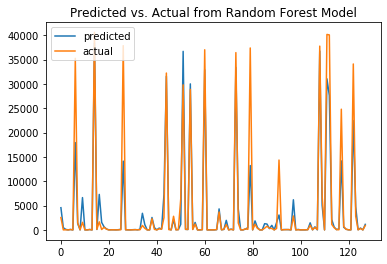

In [460]:
plt.plot(y_pred_RF_grid)
plt.plot(y_test)
plt.legend(['predicted', 'actual'], loc = 2)
plt.title('Predicted vs. Actual from Random Forest Model')

In [453]:
y_test

array([2.5380e+03, 7.0000e+00, 3.3000e+01, 0.0000e+00, 7.9000e+01,
       0.0000e+00, 3.5272e+04, 1.4510e+03, 1.4000e+01, 1.5610e+03,
       1.0000e+01, 0.0000e+00, 6.9000e+01, 0.0000e+00, 4.0630e+04,
       1.1300e+02, 1.6640e+03, 8.3000e+01, 5.4200e+02, 1.5100e+02,
       1.0000e+00, 2.0000e+01, 2.2000e+01, 5.0000e+00, 1.6000e+01,
       3.4000e+01, 3.7873e+04, 2.6000e+01, 7.0000e+00, 5.0000e+00,
       2.3000e+01, 3.6000e+01, 3.3000e+01, 3.4000e+01, 9.1800e+02,
       3.3000e+02, 3.0000e+00, 0.0000e+00, 2.3020e+03, 1.1800e+02,
       2.0000e+00, 2.2000e+02, 1.5200e+02, 2.5380e+03, 3.2244e+04,
       6.5000e+01, 3.0000e+00, 2.8010e+03, 1.1000e+01, 6.3000e+01,
       6.3880e+03, 2.9822e+04, 1.1800e+02, 9.6000e+01, 2.8886e+04,
       8.2000e+01, 1.2050e+03, 0.0000e+00, 0.0000e+00, 4.7000e+01,
       3.7027e+04, 3.0000e+00, 1.3000e+01, 2.0000e+00, 1.1000e+01,
       7.5000e+01, 3.6910e+03, 2.0000e+01, 1.2400e+02, 1.0980e+03,
       2.0000e+00, 1.1500e+02, 5.0000e+00, 3.6446e+04, 1.4100e

In [363]:
grid_DTree = GridSearchCV(estimator=ensemble_clf[1], param_grid=parameters_list[1], 
                      n_jobs=-1, cv=3, verbose=3)
grid_DTree.fit(X_train_conc, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02),
                         'criterion': ['mse', 'friedman_mse', 'mae'],
                  

In [364]:
grid_DTree.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.01, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [423]:
DTree_best = grid_DTree.best_estimator_
y_pred_DT_grid = DTree_best.predict(X_test_conc)
print('R2 score: ', r2_score(y_pred_DT_grid , y_test), 
      '/MAE: ', np.mean(np.absolute(y_test-y_pred_DT_grid)),
   '/MSE: ', np.mean((y_test-y_pred_DT_grid) ** 2))

R2 score:  0.786340583518028 /MAE:  1572.125 /MSE:  29327971.91015625


**Conclusion:** Random Forest model with ccp_alpha = 0.005, max_depth = 15, n_estimators = 50 gives the best estimation. 
## 4. Predict Sales on product of interest

In [424]:
# import data of interest
myown = pd.read_csv('Moon_Star_Earrings/....csv')
myown = x_ray_clean(myown)

C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [439]:
# Use pipeline to clean the X data
myown_x = myown[X_lst]
myown_y = myown.Sales.values

myown_X = x_prep(myown_x, vect = vect, tfidf = tfidf, train_test = 'test')

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [426]:
#the actual sales
myown_y

array([9, 9, 9, 9, 9, 9], dtype=int64)

In [370]:
# use the decision tree model from the grid search
DTree_best.predict(myown_X)

array([15., 15., 15., 15., 15., 15.])

In [428]:
DTree.predict(myown_X)

array([14., 14., 14., 14., 14., 14.])

In [429]:
RForest.predict(myown_X)

array([12.596, 12.996, 12.916, 12.826, 12.926, 12.876])

In [431]:
RForest_best.predict(myown_X)

array([8.39713198, 8.39713198, 8.39713198, 8.51763551, 8.51763551,
       8.51763551])

Predict the sales with time.

In [444]:
# Assume the review number changes with time as well. 
timeseries = myown[X_lst].copy()
timeseries['Listing Length'] = 90*np.arange(2, 8)
timeseries['Review Count'] = 2*np.arange(2, 8)

In [446]:
timeseries_X = x_prep(timeseries, vect = vect, tfidf = tfidf, train_test = 'test')

In [449]:
time_sales = RForest_best.predict(timeseries_X)

Text(0.5, 1.0, 'Predicted Sales of the item with time')

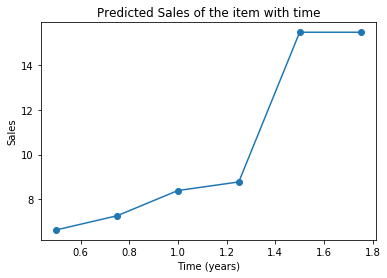

In [450]:
plt.plot(0.25*np.arange(2, 8), time_sales, 'o-')
plt.xlabel('Time (years)')
plt.ylabel('Sales')
plt.title('Predicted Sales of the item with time')